In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import DataLoader, Dataset

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
device

'cuda'

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
class IsingDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file, header=None)
        # NOTE: 磁性ラベルがなぜか-1ではなく-2になっている
        self.temperature = torch.tensor(self.data.iloc[:,0].values, dtype=torch.float32)
        self.spins = torch.tensor(self.data.iloc[:,1:-2].values, dtype=torch.float32).view(-1,1,20,20)
        self.labels = torch.tensor(self.data.iloc[:,-2].values, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.temperature[idx],self.spins[idx], self.labels[idx]

In [7]:
train_dataset = IsingDataset('/content/drive/MyDrive/Colab Notebooks/train.csv')
val_dataset = IsingDataset('/content/drive/MyDrive/Colab Notebooks/val.csv')

In [8]:
train_dataset.spins[0].shape

torch.Size([1, 20, 20])

In [9]:
# CNN
class ising2d_classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.classifier = nn.Linear(in_features=64 * 5 * 5, out_features=1)
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0),-1)
        x = self.classifier(x)
        x = torch.sigmoid(x)
        return x


In [10]:
model = ising2d_classifier()

In [11]:
batch_size = 128
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [12]:
model.to(device)

ising2d_classifier(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
  )
  (classifier): Linear(in_features=1600, out_features=1, bias=True)
)

In [13]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [14]:
num_epoch = 20
losses = []
accs = []
val_losses = []
val_accs = []
batch_size = 128
for epoch in range(num_epoch):
    running_loss = 0.0
    running_acc = 0.0
    # ＿getitem__で return features, labelsにしているから、input,labelsの順番にこれらが入る
    for _,input, labels in train_data_loader:
        input = input.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(input)
        output = output.view(-1)
        loss = criterion(output, labels)
        running_loss += loss.item()
        # 正解率の計算あまりよくないかも
        running_acc += torch.mean(((labels - output).abs() < 0.5).float())
        loss.backward()
        optimizer.step()
    running_loss  /= len(train_data_loader)
    running_acc /= len(train_data_loader)
    losses.append(running_loss)
    accs.append(running_acc.cpu())
    #
    # validation
    #
    val_running_loss = 0.0
    val_running_acc = 0.0
    for _,val_input, val_labels in val_data_loader:
        val_input = val_input.to(device)
        val_labels = val_labels.to(device)
        val_output = model(val_input)
        val_output = val_output.view(-1)
        val_loss = criterion(val_output, val_labels)
        val_running_loss += val_loss.item()
        val_running_acc += torch.mean(((val_labels - val_output).abs() < 0.5).float())
    val_running_loss /= len(val_data_loader)
    val_running_acc /= len(val_data_loader)
    val_losses.append(val_running_loss)
    val_accs.append(val_running_acc.cpu())
    print("epoch:{}, loss:{}, acc:{}, val loss:{}, val acc:{}, \
    ".format(epoch+1, running_loss, running_acc, val_running_loss, val_running_acc))


epoch:1, loss:0.6713509805062238, acc:0.6374080777168274, val loss:0.6444026877482733, val acc:0.5525174140930176,     
epoch:2, loss:0.5895659327507019, acc:0.6209648251533508, val loss:0.5692778080701828, val acc:0.6794704794883728,     
epoch:3, loss:0.47373419649460735, acc:0.781395673751831, val loss:0.4477008531490962, val acc:0.8391927480697632,     
epoch:4, loss:0.32683637825881734, acc:0.946579098701477, val loss:0.3086559325456619, val acc:0.9576823115348816,     
epoch:5, loss:0.1828139792470371, acc:0.9894301295280457, val loss:0.18034859001636505, val acc:0.990234375,     
epoch:6, loss:0.08640390853671466, acc:1.0, val loss:0.09946007716159026, val acc:0.9947916865348816,     
epoch:7, loss:0.03865929594373002, acc:1.0, val loss:0.06248574610799551, val acc:0.994140625,     
epoch:8, loss:0.02025912789737477, acc:1.0, val loss:0.04477535064021746, val acc:0.9954427480697632,     
epoch:9, loss:0.012454246033859603, acc:1.0, val loss:0.03289803839288652, val acc:0.9941406

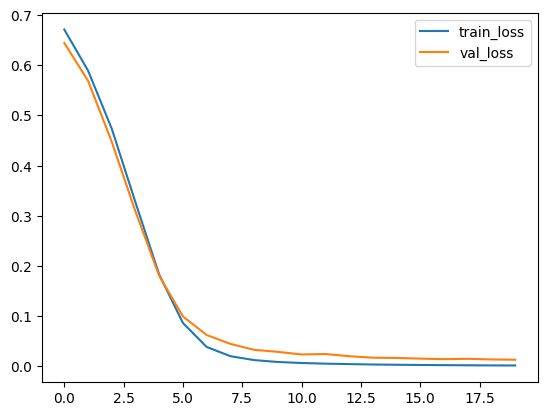

In [15]:
plt.plot(losses, label='train_loss')
plt.plot(val_losses,label='val_loss')
plt.legend()

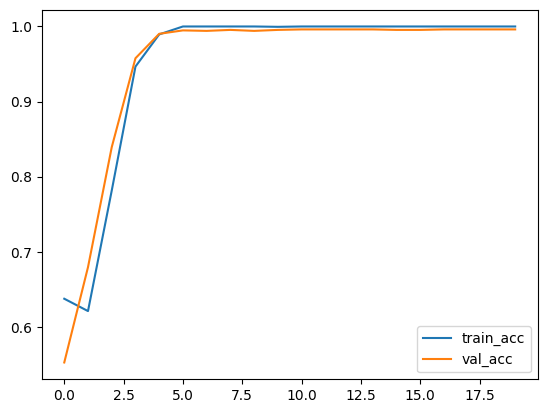

In [16]:
plt.plot(accs, label='train_acc')
plt.plot(val_accs,label='val_acc')
plt.legend()

In [17]:
val_temp = []
val_pred_labels = []
for temp,spins, labels in val_data_loader:
    val_spins = spins.to(device)
    val_labels = labels.to(device)
    val_output = model(val_spins)
    val_output = val_output.view(-1)
    val_temp.extend(temp.numpy())
    val_pred_labels.extend(val_output.cpu().detach().numpy())


In [18]:
# 温度ごとにラベルの平均をとる
df = pd.DataFrame({'temp':val_temp, 'pred_labels':val_pred_labels})
result = df.groupby('temp').mean()

Text(0, 0.5, 'labels')

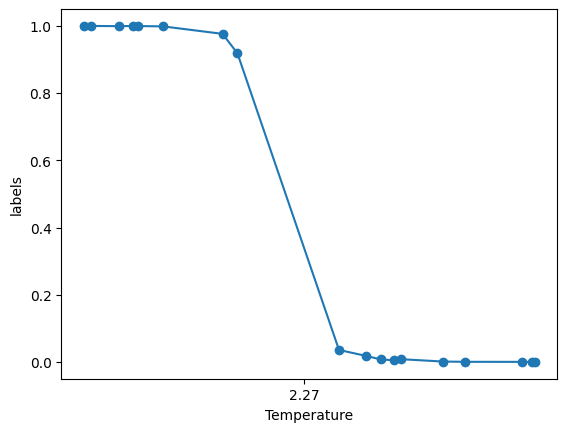

In [19]:
plt.scatter(result.index, result.values)
plt.plot(result.index, result.values)
plt.xticks([2.27])
plt.xlabel('Temperature')
plt.ylabel('labels')